In [9]:
from brian2 import *
import csv
import numpy as np
import os

In [10]:
#Test read one file
file = []
with open("test.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader: # each row is a list
        if (np.any(np.array(row, dtype=int))):
            file.append(row)
file = np.array(file).astype(int)

In [11]:
dataset = []
labels = []

for filename in os.listdir("dataset/"):
   labels.append(filename.split('_')[0])
   data = []
   with open(f"dataset/{filename}", 'r') as csvfile:
      reader = csv.reader(csvfile)
      for row in reader: # each row is a list
         if (np.any(np.array(row, dtype=int))):
            data.append(row)

   dataset.append(np.array(data).astype(int))

dataset = np.array(dataset, dtype=object)

In [12]:
dataset.shape

(40,)

In [13]:
frame_delay = 10*ms

# Extract the which neurons spikes and at which times they spike
def extract_spikes(file):
    spikes_indices = []
    spikes_times = []

    frame_count = 1

    for frame in file:
        for index in range(len(frame)):
            if frame[index] > 0:
                # print(index, frame_count*dt)
                spikes_indices.append(index)
                spikes_times.append(frame_count*frame_delay)
        frame_count += 1
        
    return spikes_indices, spikes_times

In [14]:
spike_dataset = []
for data in dataset:
    spikes_indices, spikes_times = extract_spikes(data)
    spike_dataset.append((spikes_indices, spikes_times))

In [15]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [ ]:
start_scope()

# Neuron paramenters
num_inputs = 100
num_hidden = 40

tau_mem = 20*ms
tau_syn = 2*ms
v_rest = -70*mV
R = 100*Mohm
I_inputToHidden = 0.1*nA
I_inhibToOut = -20*nA
I_outToInhib = 2*nA
# LIF equation
eqs = '''
dv/dt = (v_rest - v + R*(I_syn + I_inject)) / tau_mem : volt (unless refractory)
dI_syn/dt = -I_syn/tau_syn : ampere
I_inject : ampere
'''
thres = 'v>-55*mV'
reset = 'v=-80*mV'
refract_time = 1*ms

I_inject = 0

# Init Neuron layers
Input = SpikeGeneratorGroup(num_inputs, [0], [0*ms]) # a dummy input as set set the inout for each train/test sample
Hidden = NeuronGroup(num_hidden, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
Inhib = NeuronGroup(2, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
Output = NeuronGroup(2, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')

# Set neuron voltage to resting before running the simulation
Hidden.v = v_rest
Inhib.v = v_rest
Output.v = v_rest

# Synapse parameters
taupre = taupost = 2*ms
wmax = 1000 * pA
wmax2 = 200 * pA
wmin = 10 * pA
Apre = 10 * mA
Apost = -Apre*taupre/taupost*1.05


# Create and connect synapses
# InputToHidden = Synapses(Input, Hidden, '''
#                         w : ampere
#                         dapre/dt = -apre/taupre : ampere (event-driven)
#                         dapost/dt = -apost/taupost : ampere (event-driven)
#                         ''',
#                         on_pre='''
#                         I_syn_post += w
#                         apre += Apre
#                         w = clip(w+apost, wmin, wmax/10)
#                         ''',
#                         on_post='''
#                         apost += Apost
#                         w = clip(w+apre, wmin, wmax/10)
#                         ''', method='linear')
InputToHidden = Synapses(Input, Hidden, 'w : ampere', on_pre='I_syn += w')
InputToHidden.connect()
InputToHidden.w = 'rand() * I_inputToHidden'

HiddenToOutput = Synapses(Hidden, Output, '''
                        w : ampere
                        dapre/dt = -apre/taupre : ampere (event-driven)
                        dapost/dt = -apost/taupost : ampere (event-driven)
                        ''',
                        on_pre='''
                        I_syn_post += w
                        apre += Apre
                        w = clip(w+apost, wmin, wmax)
                        ''',
                        on_post='''
                        apost += Apost
                        w = clip(w+apre, wmin, wmax)
                        ''', method='linear')
HiddenToOutput.connect()
HiddenToOutput.w = 'rand() * wmax'

# HiddenToInhib = Synapses(Hidden, Inhib, '''
#                         w : ampere
#                         dapre/dt = -apre/taupre : ampere (event-driven)
#                         dapost/dt = -apost/taupost : ampere (event-driven)
#                         ''',
#                         on_pre='''
#                         I_syn_post += w
#                         apre += Apre
#                         w = clip(w+apost, wmin, wmax2)
#                         ''',
#                         on_post='''
#                         apost += Apost
#                         w = clip(w+apre, wmin, wmax2)
#                         ''', method='linear')
# HiddenToInhib.connect()
# HiddenToInhib.w = 'rand() * wmax2'

OutputToInhib = Synapses(Output, Inhib, on_pre='I_syn += I_outToInhib')
OutputToInhib.connect(condition='i==j')

InhibToOutput = Synapses(Inhib, Output , on_pre='I_syn += I_inhibToOut')
InhibToOutput.connect(condition='i!=j')

# Monitors
monitorSpikesInput = SpikeMonitor(Input)
monitorSpikesHidden = SpikeMonitor(Hidden)
monitorHidden = StateMonitor(Hidden, ['v', 'I_syn'], record=True)
monitorOutput = StateMonitor(Output, ['v', 'I_syn'], record=True)
monitorInhib = StateMonitor(Inhib, ['v', 'I_syn'], record=True)

network = Network(Input, Hidden, Output, Inhib, InputToHidden, HiddenToOutput, OutputToInhib, InhibToOutput, monitorSpikesInput, monitorSpikesHidden, monitorHidden, monitorOutput, monitorInhib)

network.store

run_to = 0*ms

index_list = []
for index in range(10): #TODO change to 20
    # index_list.append(index)
    # index_list.append(index+20)
    index_list.append(7)
    index_list.append(27)


for index in index_list:

    network.restore

    Input.set_spikes(spike_dataset[index][0], spike_dataset[index][1] + run_to)

    Hidden.v = v_rest
    Inhib.v = v_rest
    Output.v = v_rest

    Hidden.I_syn = 0
    Inhib.I_syn = 0
    Output.I_syn = 0

    if index < 20:
        Output[0].I_inject = 0.2*nA
        Output[1].I_inject = -0.8*nA
    else:
        Output[0].I_inject = -0.8*nA
        Output[1].I_inject = 0.2*nA

    print(f"Running training sample {index} \t {network.t}")

    run_time = frame_delay * len(dataset[index])
    run_to += run_time

    network.run(run_time)
    
    network.store


Running training sample 7 	 0. s


WARNING    'I_inject' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_inject' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_inject' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running training sample 27 	 140. ms
Running training sample 7 	 0.33 s
Running training sample 27 	 0.47 s
Running training sample 7 	 0.66 s
Running training sample 27 	 0.8 s
Running training sample 7 	 0.99 s
Running training sample 27 	 1.13 s
Running training sample 7 	 1.32 s
Running training sample 27 	 1.46 s
Running training sample 7 	 1.65 s
Running training sample 27 	 1.79 s
Running training sample 7 	 1.98 s
Running training sample 27 	 2.12 s
Running training sample 7 	 2.31 s
Running training sample 27 	 2.45 s
Running training sample 7 	 2.64 s
Running training sample 27 	 2.78 s
Running training sample 7 	 2.97 s
Running training sample 27 	 3.11 s


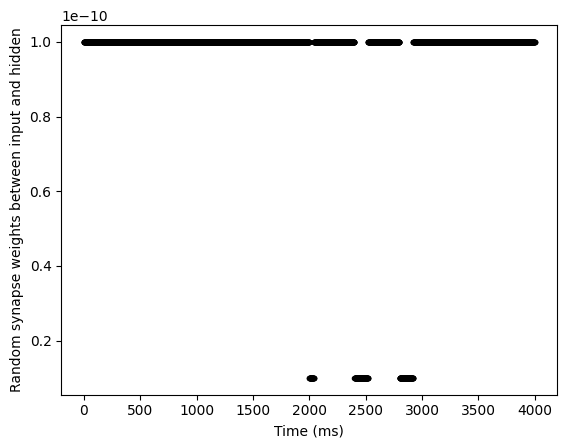

In [ ]:
x = [x for x in range(len(InputToHidden.w[:]))]

plot(x, InputToHidden.w[:], '.k')
xlabel('Time (ms)')
ylabel('Random synapse weights between input and hidden');

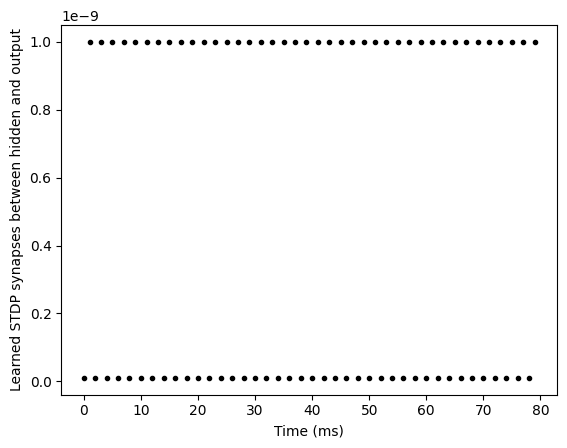

In [ ]:
x = [x for x in range(num_hidden*2)]

plot(x, HiddenToOutput.w[:], '.k')
xlabel('Time (ms)')
ylabel('Learned STDP synapses between hidden and output');

In [ ]:
# Try test one
network.restore

test_sample = 27

Input.set_spikes(spike_dataset[test_sample][0], spike_dataset[test_sample][1] + run_to)

Hidden.v = v_rest
Inhib.v = v_rest
Output.v = v_rest

Hidden.I_syn = 0
Inhib.I_syn = 0
Output.I_syn = 0

Output[0].I_inject = 0
Output[1].I_inject = 0

print(f"Running test: {network.t}")

run_time = frame_delay * len(dataset[38])
run_to += run_time

monitorTestSpikes = SpikeMonitor(Output)

network.add(monitorTestSpikes)

network.run(run_time)

Running test: 3.3 s


In [ ]:
# Output[0].I_inject = 0
# Output[1].I_inject = 0
# for index in index_list:

#     network.restore

#     Input.set_spikes(spike_dataset[index][0], spike_dataset[index][1] + run_to)

#     Hidden.v = v_rest
#     Inhib.v = v_rest
#     Output.v = v_rest

#     Hidden.I_syn = 0
#     Inhib.I_syn = 0
#     Output.I_syn = 0

#     monitorTestSpikes = SpikeMonitor(Output)

#     network.add(monitorTestSpikes)

#     print(f"Running test sample {index} \t {network.t}  \t", end="")

#     run_time = frame_delay * len(dataset[index])
#     run_to += run_time

#     network.run(run_time)

#     unique, counts = numpy.unique(monitorTestSpikes.i, return_counts=True)
#     result = dict(zip(unique, counts))
#     print(result)
#     try:
#         label = max(result, key=result.get)
#         if label == '0':
#             label = 'right'
#         else:
#             label = 'left'

#         print(f"Result: {monitorTestSpikes.i} => {label}")
#     except:
#         print("No spikes :(")

In [ ]:
monitorTestSpikes.i

<spikemonitor_36.i: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])>

In [ ]:
unique, counts = numpy.unique(monitorTestSpikes.i, return_counts=True)
dict(zip(unique, counts))

{1: 24}

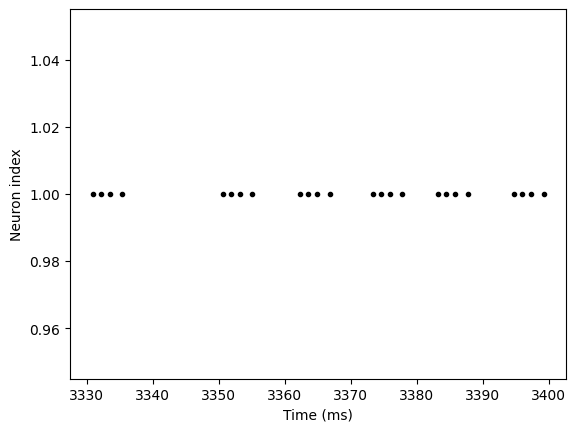

In [ ]:
plot(monitorTestSpikes.t/ms, monitorTestSpikes.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

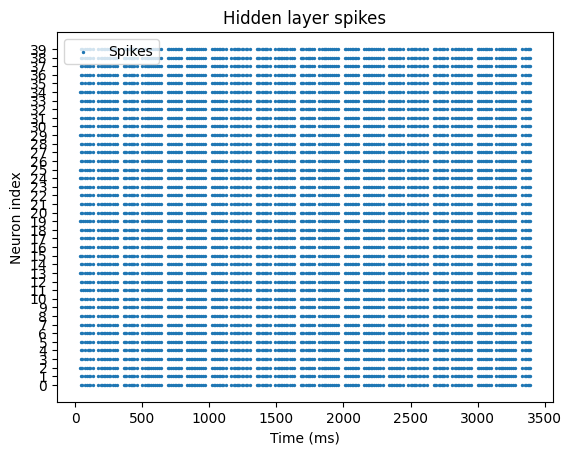

In [ ]:
yticks(np.arange(0, max(monitorSpikesHidden.i)+1, 1))
scatter(monitorSpikesHidden.t/ms, monitorSpikesHidden.i[:], 2, label="Spikes")
xlabel('Time (ms)')
ylabel('Neuron index')
title('Hidden layer spikes')
# xlim(4000,6000)
legend();

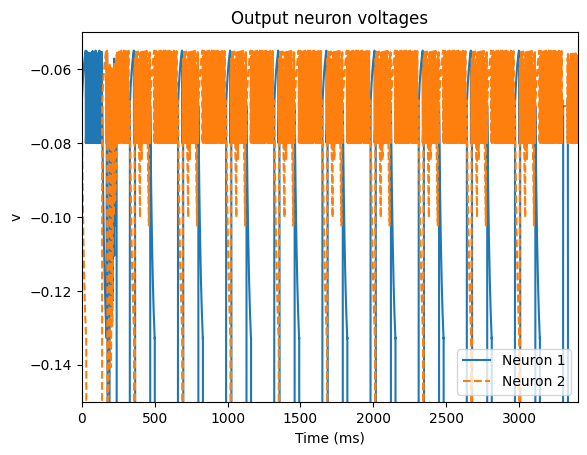

In [ ]:
plot(monitorOutput.t/ms, monitorOutput.v[0], label='Neuron 1')
plot(monitorOutput.t/ms, monitorOutput.v[1], '--',label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Output neuron voltages')
xlim(0,run_to/ms)
xlim(run_to/ms-200,run_to/ms)
# xlim(800,1000)
ylim(-0.15,-0.05)
legend();

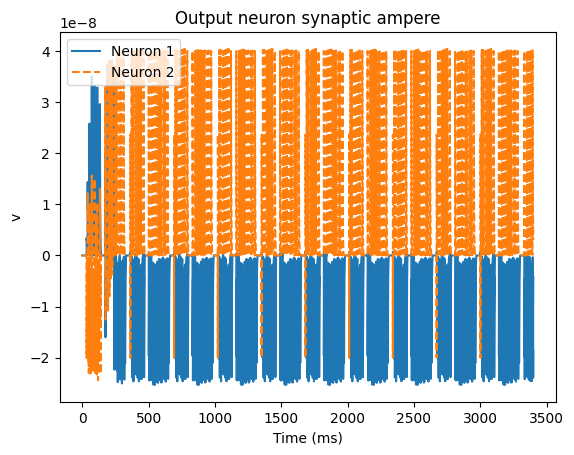

In [ ]:
plot(monitorOutput.t/ms, monitorOutput.I_syn[0], label='Neuron 1')
plot(monitorOutput.t/ms, monitorOutput.I_syn[1], '--', label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Output neuron synaptic ampere')
legend();

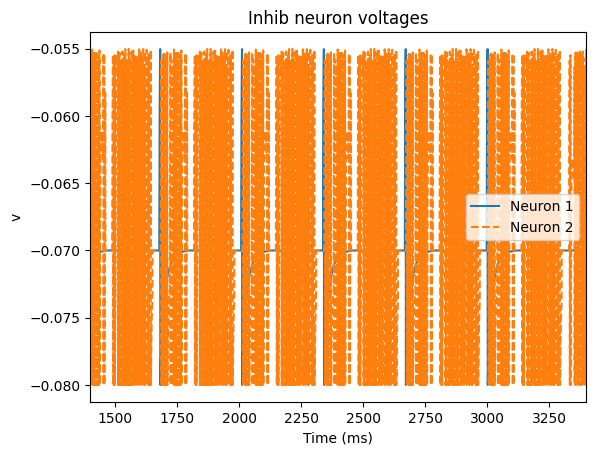

In [ ]:
plot(monitorInhib.t/ms, monitorInhib.v[0], label='Neuron 1')
plot(monitorInhib.t/ms, monitorInhib.v[1], '--', label='Neuron 2')
xlabel('Time (ms)')
xlim(run_to/ms-2000,run_to/ms)

ylabel('v')
title('Inhib neuron voltages')
legend();

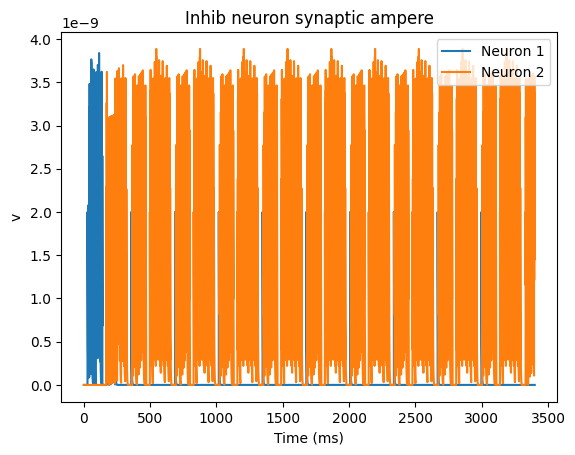

In [ ]:
plot(monitorInhib.t/ms, monitorInhib.I_syn[0], label='Neuron 1')
plot(monitorInhib.t/ms, monitorInhib.I_syn[1], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Inhib neuron synaptic ampere')
legend();

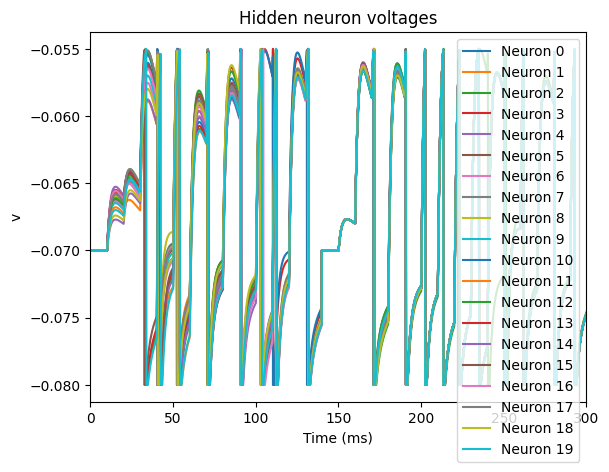

In [ ]:
for i in range(20):
    plot(monitorHidden.t/ms, monitorHidden.v[i], label=f'Neuron {i}')
# plot(monitorHidden.t/ms, monitorHidden.v[2], label=f'Neuron {2}')

xlabel('Time (ms)')
ylabel('v')
title('Hidden neuron voltages')
xlim(0,run_to/ms)
xlim(run_to/ms - 300,run_to/ms)
xlim(0,300)
legend()